In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

%load_ext autoreload
%autoreload 2

In [2]:
DATADIR = Path('data')

# Feature selection

In [3]:
from data_processing import *
import data_processing as dp

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

def train(
    TYPE='classification', TARGET='value', SPLIT_BY_PARTICIPANT=False, 
    TEST_TAKE_FIRST=0, SEED=550, return_csv=False, feature_selection=False):
    
    phq9 = dp.load_phq9_targets(DATADIR / 'df_phq9.csv', type=TYPE, target=TARGET)
    locations = load_locations(DATADIR / 'df_location_ratio.csv')
    demographics = load_demographics(DATADIR / 'df_demographics.csv')
    #mobility = load_passive_mobility(DATADIR / 'df_passive_mobility_features.csv')
    #phone = load_passive_phone(DATADIR / 'df_passive_phone_communication_features_brighten_v2.csv')

    combined, merge_result = dp.combine(
        phq9, 
        dailies=[
            ('locations', locations), 
            # ('mobility', mobility),
            # ('phone', phone)
        ], 
        constants=[
            demographics
        ],
        prev_phq9=False
    )
    combined = dp.rf_preprocess(combined)

    if return_csv:
        return combined
    
    if SPLIT_BY_PARTICIPANT:
        x_train, x_test, y_train, y_test = dp.train_test_split_participant(combined, 0.15, random_state=SEED,
                                                                           test_take_first=TEST_TAKE_FIRST)
    else:
        x, y = dp.xy_split(combined)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=SEED, stratify=y)

    print('Train set shape:', x_train.shape)
    print('Test set shape:', x_test.shape)
    n = len(y_train) + len(y_test)
    train_pct = len(y_train) / n * 100
    test_pct = len(y_test) / n * 100
    print(f'Ratio: {train_pct:.2f}%/{test_pct:.2f}%')
    print()


    if TYPE == 'regression':
        def rmse(x, y):
            return np.sqrt(((x - y)**2).mean())

        model = RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=SEED)
        model.fit(x_train, y_train)

        train_rmse = rmse(y_train, model.predict(x_train))
        test_rmse = rmse(y_test, model.predict(x_test))
        print(f'Train set RMSE: {train_rmse:.4f}')
        print(f'Test set RMSE:  {test_rmse:.4f}')

        train_score = model.score(x_train, y_train)
        test_score = model.score(x_test, y_test)
        print(f'Train score:', train_score)
        print(f'Test score:', test_score)
        #return train_score, test_score
        
        if feature_selection == True:
            combined = combined.drop(columns=['participant_id', 'date', 'target'])
            feature_importances = pd.DataFrame({'feature': combined.columns, 'importance': model.feature_importances_})
            feature_importances = feature_importances.sort_values('importance', ascending=False).reset_index(drop=True)
            #print(feature_importances)
            plt.figure(figsize=(10, 10))
            sns.barplot(x='importance', y='feature', data=feature_importances)
            plt.show()

            print('-'*25)
            print("After feature selection:")
            sfm = SelectFromModel(model, threshold=0.01, prefit=True)
            x_train_new = sfm.transform(x_train)
            x_test_new = sfm.transform(x_test)
            print('Train set shape:', x_train_new.shape)
            print('Test set shape:', x_test_new.shape)
            print()
            sfm.estimator.fit(x_train_new, y_train)
            train_score = sfm.estimator.score(x_train_new, y_train)
            test_score = sfm.estimator.score(x_test_new, y_test)
            print(f'Train score:', train_score)
            print(f'Test score:', test_score)


    elif TYPE == 'classification':
        model = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=SEED)
        model.fit(x_train, y_train)

        train_acc = 100 * model.score(x_train, y_train)
        test_acc = 100 * model.score(x_test, y_test)
        print(f'Train set accuracy: {train_acc:.2f}%') 
        print(f'Test set accuracy:  {test_acc:.2f}%')

        if feature_selection == True:
            combined = combined.drop(columns=['participant_id', 'date', 'target'])
            feature_importances = pd.DataFrame({'feature': combined.columns, 'importance': model.feature_importances_})
            feature_importances = feature_importances.sort_values('importance', ascending=False).reset_index(drop=True)
            #print(feature_importances)
            plt.figure(figsize=(10, 10))
            sns.barplot(x='importance', y='feature', data=feature_importances)
            plt.show()

            print('-'*25)
            print("After feature selection:")
            sfm = SelectFromModel(model, threshold=0.01, prefit=True)
            x_train_new = sfm.transform(x_train)
            x_test_new = sfm.transform(x_test)
            print('Train set shape:', x_train_new.shape)
            print('Test set shape:', x_test_new.shape)
            print()
            sfm.estimator.fit(x_train_new, y_train)
            train_acc = 100 * sfm.estimator.score(x_train_new, y_train)
            test_acc = 100 * sfm.estimator.score(x_test_new, y_test)
            print(f'Train set accuracy: {train_acc:.2f}%') 
            print(f'Test set accuracy:  {test_acc:.2f}%')
                
        # y_full = np.concatenate((y_train, y_test))
        # random_acc = 100 * (y_full == np.random.randint(0, 5, size=y_full.shape)).mean()
        # print(f'Random full accuracy: {random_acc:.2f}%')

        # figs, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # print('Train set:')
        # train_bal, train_mean = metrics.accuracy_info(y_train, model.predict(x_train), prefix='Training', ax=axes[0])

        # print('Test set:')
        # test_bal, test_mean = metrics.accuracy_info(y_test, model.predict(x_test), prefix='Test', ax=axes[1])
        
        #return train_bal, test_bal

### Classification, value, no split by participant

Train set shape: (986, 61)
Test set shape: (175, 61)
Ratio: 84.93%/15.07%

Train set accuracy: 94.52%
Test set accuracy:  50.29%


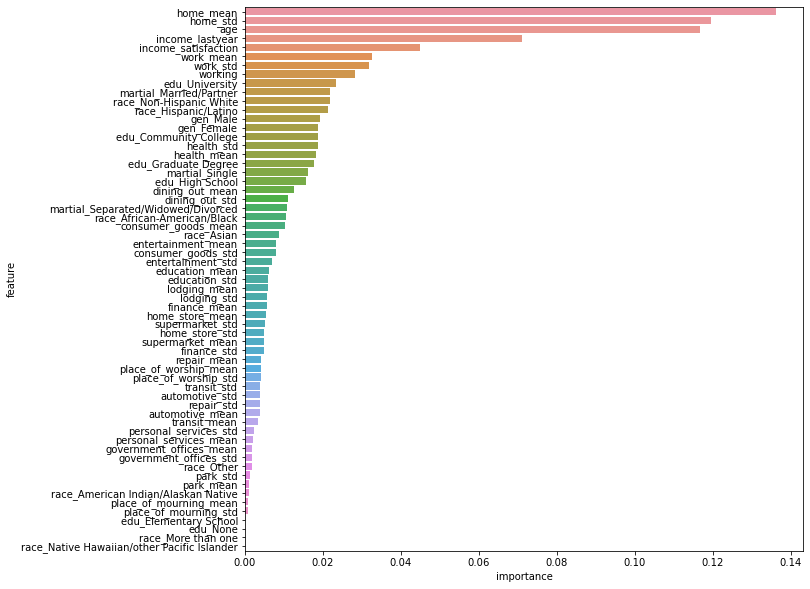

-------------------------
After feature selection:
Train set shape: (986, 25)
Test set shape: (175, 25)

Train set accuracy: 94.52%
Test set accuracy:  53.71%


In [4]:
train(
        TYPE='classification', TARGET='value', SPLIT_BY_PARTICIPANT=False,
        TEST_TAKE_FIRST=0, SEED=550, return_csv=False, feature_selection=True)

### Classification, value, split by participant

Train set shape: (969, 61)
Test set shape: (192, 61)
Ratio: 83.46%/16.54%

Train set accuracy: 94.12%
Test set accuracy:  26.56%


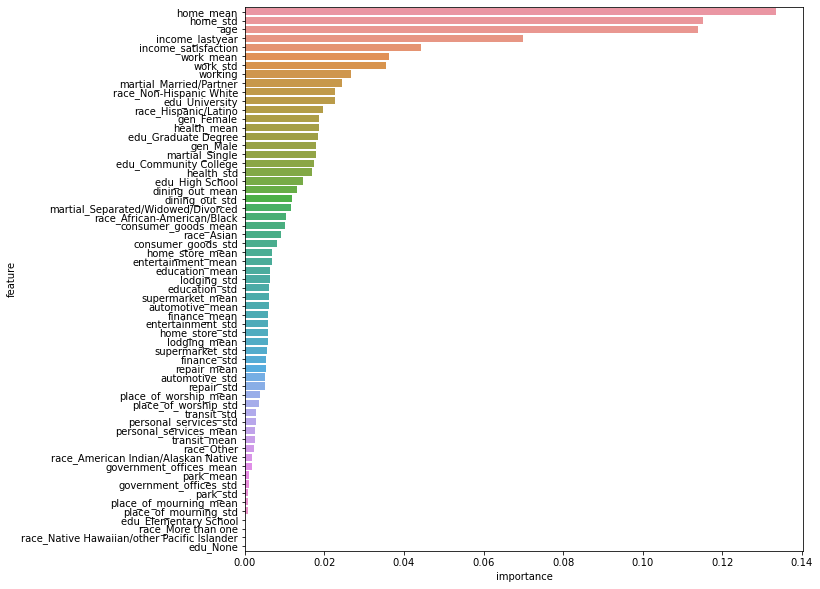

-------------------------
After feature selection:
Train set shape: (969, 25)
Test set shape: (192, 25)

Train set accuracy: 93.91%
Test set accuracy:  28.65%


In [5]:
train(
    TYPE='classification', TARGET='value', SPLIT_BY_PARTICIPANT=True,
    TEST_TAKE_FIRST=0, SEED=550, return_csv=False, feature_selection=True)

### Regression, value, no split by participant

Train set shape: (986, 61)
Test set shape: (175, 61)
Ratio: 84.93%/15.07%

Train set RMSE: 1.8740
Test set RMSE:  4.6670
Train score: 0.9082260939407909
Test score: 0.43258074060126384


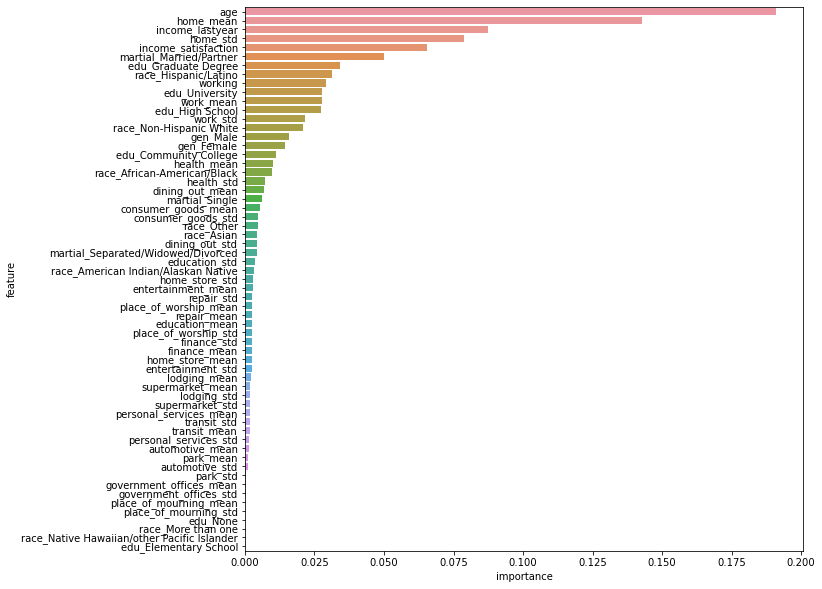

-------------------------
After feature selection:
Train set shape: (986, 18)
Test set shape: (175, 18)

Train score: 0.9083353192492473
Test score: 0.4411883347172634


In [7]:
train(
        TYPE='regression', TARGET='value', SPLIT_BY_PARTICIPANT=False, 
        TEST_TAKE_FIRST=0, SEED=550, return_csv=False, feature_selection=True)

### Regression, value, split by participant

Train set shape: (969, 61)
Test set shape: (192, 61)
Ratio: 83.46%/16.54%

Train set RMSE: 1.9264
Test set RMSE:  6.2803
Train score: 0.9028289144581078
Test score: -0.019671850828450577


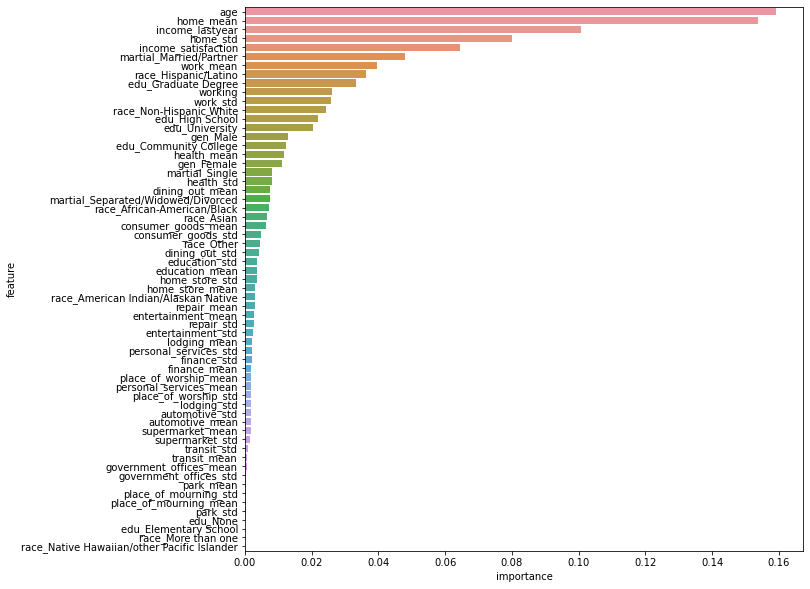

-------------------------
After feature selection:
Train set shape: (969, 18)
Test set shape: (192, 18)

Train score: 0.9019506853702722
Test score: 0.027260260637250955


In [8]:
train(
    TYPE='regression', TARGET='value', SPLIT_BY_PARTICIPANT=True,
    TEST_TAKE_FIRST=0, SEED=550, return_csv=False, feature_selection=True)

## Previous train method

In [ ]:
train(type='classification', target='value', feature_selection=True)

In [ ]:
train(type='classification', target='diff', feature_selection=True)

In [ ]:
train(type='regression', target='value', feature_selection=True)

In [ ]:
train(type='regression', target='diff', feature_selection=True)

# Group features

In [ ]:
locations = load_locations(DATADIR / 'df_location_ratio.csv')
locations = locations.iloc[:, 2:]
locations

In [ ]:
# merge columns 'consumer_goods', 'home_store', 'supermarket' of locations into one column "store"


# Merge columns 0, 1, 2 into new column



In [ ]:
# automotive, repair

# place of mourning, place of worship

# finance, government_offices, personal_services, 

# dining_out, entertainment, lodging, park

# health

# finance

# education

# transit 


# home

# work